# Market Making Strategy with Cryptocurrencies

In this notebook, I will be implementing the market-making methodology outlined in Avellaneda and Stoikov's popular market making whitepaper titled High-Frequency Trading in a Limit Order Book. The paper can be found for free here: https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

In the whitepaper, the optimal behaviour of a market maker given certain assumptions is derived. Ultimately, this derivation yields a bid/ask spread that is defined as follows:

$$
\text{bid / ask spread} = \gamma \sigma ^2 (T - t) + \frac{2}{\gamma}\ln\left(1 + \frac{\gamma}{k}\right)
$$

This spread is defined around a reservation price i.e. a price at which a market maker is indifferent between their current portfolio and their current portfolio + a new share. The reservation price is derived in the whitepaper as follows:

$$
\text{reservation price} = s - q\gamma\sigma^2(T-t)
$$

The variables mentioned in the above definitions are as follows:

* $s = S_t$ i.e. the per-unit price of an asset at time $t$
* $T$, the terminus of the time series 
* $\sigma$, the volatility of the asset 
* $q$, the number of assets held in inventory
* $\gamma$, a risk factor that is adjusted to meet the risk/return trade-off of the market maker
* $x$, the initial capital of the market maker
* $k$, the intensity of the arrival of orders


# 0 - Implementation of the Paper

Now that we have an idea of where to start, let us first implement the simulation that is done in the paper, and see if we can translate it directly to the crypo pairs that we picked earlier.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [96]:
# Create a brownian motion generator
def brownian_motion(x0, n, dt, sigma):
    
    # x0 is an array of initial conditions
    x0 = np.array(x0)
    
    # Generate normal random variables
    r = np.random.normal(size = x0.shape + (n,), scale = sigma*np.sqrt(dt))
    
    # Calculate cumulative sum of random variables
    cumsum = np.cumsum(r, axis=1)
    
    # Add in initial conditions
    cumsum += np.expand_dims(x0, axis=-1)
    
    cumsum[:,0] = x0
    
    return cumsum

In [97]:
# Sanity Check
brownian_motion([100,102], 20, 0.005, 2)

array([[100.        ,  99.72873457,  99.81256616, 100.05076017,
         99.89718526,  99.86352087,  99.54779064,  99.68029434,
         99.46754058,  99.57683659,  99.57833343,  99.30961624,
         99.24499488,  99.22394462,  99.17891108,  99.13081884,
         99.08389386,  99.0531074 ,  99.24406963,  99.17635092],
       [102.        , 101.95063648, 102.20491585, 102.38002499,
        102.40517432, 102.41283074, 102.30314073, 102.48199023,
        102.60135417, 102.74146875, 102.83925284, 102.72487711,
        102.77271691, 102.85155839, 102.65660463, 102.98150337,
        102.84762847, 102.48117848, 102.31659999, 102.43351057]])

In [149]:
# Sample Brownian Motion

# Initial stock price
s0 = 100

# Number of time steps
N = 20000

# Terminus 
T = 1

# Step size
dt = T/N

# Stdev
sigma = 2

# Initialize empty array to keep track of
# Evolution of simulated stock price
s = brownian_motion([s0], N, dt, sigma)

<AxesSubplot:>

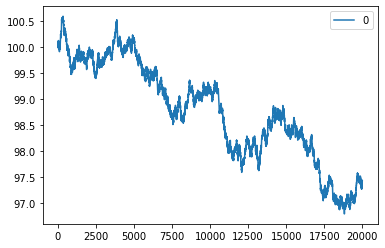

In [150]:
# Rough graph of stock evolution
pd.DataFrame(s).T.plot()

In [151]:
np.shape(s)

(1, 20000)

In [152]:
s = s[0]

Since crypto markets do not close, we will be implementing the version of the model that has an infinite time horizon. This means that some new parameters will need to be defined, including:

* $\omega$, the upper bound of inventory that the market maker is allowed to have

In [153]:
# Define variables for our market maker

# Initialize empty array for pnl
pnl = np.zeros(N+1)

# Capital 
x = np.zeros(N+1)

# Inventory
q = np.zeros(N+1)
q_max = 5

# Reserve price
r = np.zeros(N)

# Optimal bid/ask
r_a = np.zeros(N+1)
r_b = np.zeros(N+1)

# Risk tolerance of market maker
gamma = 0.5

# Intensity of arrival orders
k = 2

# Order consumption probability factors
M = s0 / N
A = np.exp(k*M/2)/dt

# Keep track of max/mins
max_q_held = 0
min_q_held = 0

In [154]:
for i in range(N):
    omega = 1/2 * gamma **2 * sigma**2 * (q_max+1)**2
    
    coef = gamma**2 * sigma**2 /(2*omega-gamma**2 * q[i]**2 * sigma**2)
    
    r_a[i] = s[i] + np.log(1+(1-2*q[i])*coef)/gamma
    r_b[i] = s[i] + np.log(1+(-1-2*q[i])*coef)/gamma
    
    r[i] = (r_a[i] + r_b[i])/2
    
    delta_a = r_a[i] - s[i]
    delta_b = s[i] - r_b[i]
    
    lambda_a = A * np.exp(-k*delta_a)
    lambda_b = A * np.exp(-k*delta_b)
    
    y_a = random.random()
    y_b = random.random()
    
    dNa = 0
    dNb = 0
    
    prob_ask = 1-np.exp(-lambda_a*dt)
    prob_bid = 1-np.exp(-lambda_b*dt)
    
    if y_a < prob_ask:
        dNa = 1
    if y_b < prob_bid:
        dNb = 1
        
    q[i+1] = q[i] - dNa + dNb
    x[i+1] = x[i] + r_a[i]*dNa -r_b[i]*dNb
    pnl[i+1] = x[i+1] + q[i+1]*s[i]
    
    if q[i+1] > max_q_held:
        max_q_held = q[i+1]
    if q[i+1] < min_q_held:
        min_q_held = q[i+1]

pnl_sim = pnl[-1]
    
    

<AxesSubplot:>

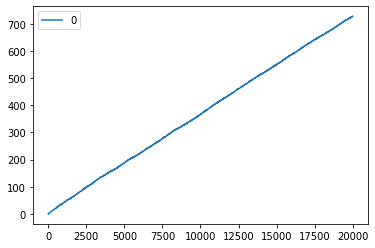

In [156]:
a = pd.DataFrame(pnl)
a.plot()

# 1 - Data

To trade in a limit order book, we must first get order book data. Kraken makes it very easy to download .csv files of their historical order book data, and also provide a REST API. Since there are limitations to the data that can be downloaded via the API, we will first work with the .csv files and if time permits, create an algorithm that extracts the data that we want. 

We will look at two crypto/USD pairs, namely Ethereum/Ether (ETH) and Covalent (CQT). The data for each pair has already been downloaded, so we can